In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score

import scipy.sparse as sp
from lightgbm import LGBMClassifier

from tqdm import tqdm

### Semi-Supervised Learning 

Semi-Supervised Learning comes under the intersection of Supervised and Unsupervised Learning, in the sense that you do not have labels for all examples but for only a few. So basically, you have a small set of labelled data and large set of unlabelled data and you want to train the model under this scenario.

Naturally, as we have a few labels, we would like to use those for our advantage. It's better than unsupervised learning since we have some additional information (some kind of prior knowledge if you will). So the general strategy is bootstrapping approach: training high-precision model on labelled examples, including examples in training with higher confidence in predictions with predicted label as ground truth label, and repeat.

This is different from Self-Supervised Learning (which is more closer to unsupervised learning), because you do not have any labelled examples in that case, **rather you make labels yourself**. Examples include: 
1. Predicting the next word in sentence, so you make data as <code>{word1, word2}</code>
2. Predicting masked words in sentence - Masked Language Modelling (MLM) as in BERT, so you mask 15% of tokens 
3. Word2Vec is self-supervised, making labels (context) as words within window size

#### Dataset Link: [Kaggle](https://www.kaggle.com/datasets/uciml/adult-census-income)

In [2]:
conf_threshold = 0.95
sample_pct = 0.1
n_iters = 150

### Steps:

1. Data Preprocessing:
    1. Since data contains many categorical columns, we will one-hot-encode them
    2. This results in highly sparse matrix, so we will perform low-rank approximation using SVD
        1. Finding appropriate number of components for SVD using Elbow Method
        2. Considering representation in latent space with dimension: <code>(n_examples, n_components)</code>
2. Train-Validation Split
3. **Self-Supervised Training:** The steps are as follows:
    1. Model Training (Bootstrapping approach):
        1. Train model with labelled examples that aims to maximize precision
        2. Make predictions on unlabelled examples
        3. Choose examples with high confidence in predictions and make them part of training
        4. Repeat steps 1, 2, 3
    2. Model Evaluation: 
        1. Evaluate on test set(hold-out set) 
        2. Check how model performance improves

In [3]:
df = pd.read_csv('semi-supervised-dataset/adult.csv')
print('Shape:', df.shape)
df.head(2)

Shape: (32561, 15)


,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K


In [4]:
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']

matrices = []
for col in categorical_columns:
    enc = OneHotEncoder()
    ohe_matrix = enc.fit_transform(df[[col]])
    matrices.append(ohe_matrix)

In [5]:
mat = sp.hstack((matrices))
sparsity = mat.sum() / (mat.shape[0] * mat.shape[1]) * 100

print('Shape:', mat.shape)
print(f'Sparsity: {sparsity.round(2)}%')

Shape: (32561, 102)
Sparsity: 7.84%


Number of Components: 5 | Error: 293.4
Number of Components: 10 | Error: 239.77
Number of Components: 15 | Error: 200.33
Number of Components: 20 | Error: 167.61
Number of Components: 25 | Error: 142.02
Number of Components: 30 | Error: 118.5
Number of Components: 40 | Error: 75.55
Number of Components: 50 | Error: 47.02


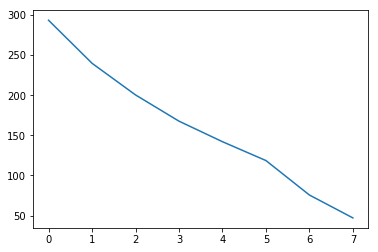

In [6]:
def reconstruction_error(P, Q):
    # P and Q are sparse matrices
    return sp.linalg.norm(P - Q)

n_components = [5, 10, 15, 20, 25, 30, 40, 50]
errors = []
for k in n_components:
    U, S, VT = sp.linalg.svds(mat, k = k)
    approx_mat = U @ np.diag(S) @ VT
    approx_mat = sp.csr_matrix(approx_mat)
    error = reconstruction_error(mat, approx_mat)
    errors.append(error)
    print(f'Number of Components: {k} | Error: {error.round(2)}')

plt.plot(errors)
plt.show()

In [7]:
U, _, _ = sp.linalg.svds(mat, k = 10)

numeric_columns = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']
X = df[numeric_columns].values
X = np.hstack((X, U))

y = df['income'].values
y = np.where(y=='<=50K', 0, 1)

In [8]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X.shape, X_test.shape, y.shape, y_test.shape

((26048, 16), (6513, 16), (26048,), (6513,))

In [9]:
def bootstrapping(model, X_train, y_train, X_val, y_val, conf_threshold):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # finding confidence in predictions
    probs = np.max(model.predict_proba(X_val), axis=1)

    # consider those whose confidence is higher than threshold
    # regardless it's positive or negative prediction
    include_idxs = np.where(probs >= conf_threshold)[0]
    exclude_idxs = np.where(probs < conf_threshold)[0]
    
    new_X_train = X_val[include_idxs]
    new_y_train = y_pred[include_idxs]
    new_X_train = np.vstack((X_train, new_X_train))
    new_y_train = np.hstack((y_train, new_y_train))

    new_X_val = X_val[exclude_idxs]
    new_y_val = y_val[exclude_idxs]
    return new_X_train, new_y_train, new_X_val, new_y_val, model

The evolution of model learning depends on initial set of examples. If the initial set changes, learning also changes. Hence, we can make different models in a way, with different sets of starting examples.

In [10]:
np.random.seed(42)

idx = np.arange(len(X))
np.random.shuffle(idx)

train_size = int(sample_pct * len(X))
train_idx = idx[:train_size]
val_idx = idx[train_size:]

X_train = X[train_idx]
y_train = y[train_idx]
X_val = X[val_idx]
y_val = y[val_idx]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2604, 16), (2604,), (23444, 16), (23444,))

In [11]:
max_score = -float('inf')
scores = []
num_training_examples = []

for n_iter in range(1, n_iters+1):
    model = LGBMClassifier()
    X_train, y_train, X_val, y_val, model = bootstrapping(model, X_train, y_train, X_val, y_val, conf_threshold)

    # predicting on hold-out set (test set)
    y_pred = model.predict(X_test)
    score = precision_score(y_test, y_pred).round(3)
    scores.append(score)
    num_training_examples.append(len(X_train))
    
    if score > max_score:
        max_score = score
        print(f'Iteration: {n_iter} | Precision: {score}')

Iteration: 1 | Precision: 0.699
Iteration: 2 | Precision: 0.719
Iteration: 3 | Precision: 0.729
Iteration: 5 | Precision: 0.732
Iteration: 7 | Precision: 0.738
Iteration: 8 | Precision: 0.743
Iteration: 10 | Precision: 0.746
Iteration: 16 | Precision: 0.747
Iteration: 20 | Precision: 0.752
Iteration: 22 | Precision: 0.754
Iteration: 28 | Precision: 0.755
Iteration: 42 | Precision: 0.758
Iteration: 51 | Precision: 0.759
Iteration: 63 | Precision: 0.76
Iteration: 67 | Precision: 0.762
Iteration: 73 | Precision: 0.763
Iteration: 74 | Precision: 0.765
Iteration: 97 | Precision: 0.768


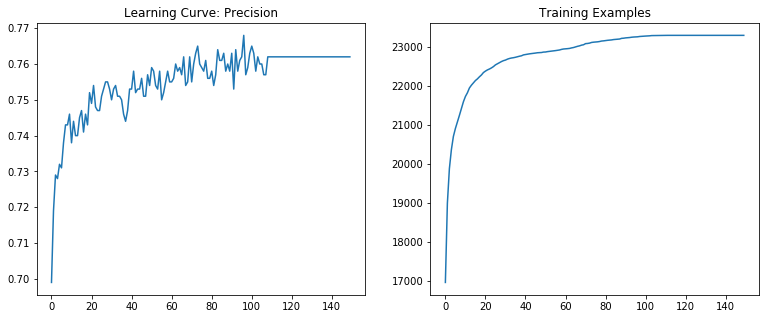

In [12]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('Learning Curve: Precision')
plt.plot(scores)

plt.subplot(132)
plt.title('Training Examples')
plt.plot(num_training_examples)
plt.show()

### Observation:

We note that the precison score improves as learning evolves. However, it converges and stops improving after a certain time